# Detect data bias

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Download dataset

# Analyze dataset
Create a Pandas DataFrame from each of the product categories.

In [4]:
import csv

df_giftcards = pd.read_csv(
    "./data-clarify/amazon_reviews_us_Gift_Card_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)

df_software = pd.read_csv(
    "./data-clarify/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)

df_videogames = pd.read_csv(
    "./data-clarify/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)

df = pd.concat([df_giftcards, df_software, df_videogames], ignore_index=True, sort=False)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,24371595,R27ZP1F1CD0C3Y,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Gift Card,5,0,0,N,Y,Five Stars,Great birthday gift for a young adult.,2015-08-31
1,US,42489718,RJ7RSBCHUDNNE,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,2015-08-31
2,US,861463,R1HVYBSKLQJI5S,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,5,0,0,N,Y,Five Stars,Good,2015-08-31
3,US,25283295,R2HAXF0IIYQBIR,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,1,0,0,N,Y,One Star,Fair,2015-08-31
4,US,397970,RNYLPX611NB7Q,B005ESMGV4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",Gift Card,5,0,0,N,Y,Five Stars,I can't believe how quickly Amazon can get the...,2015-08-31


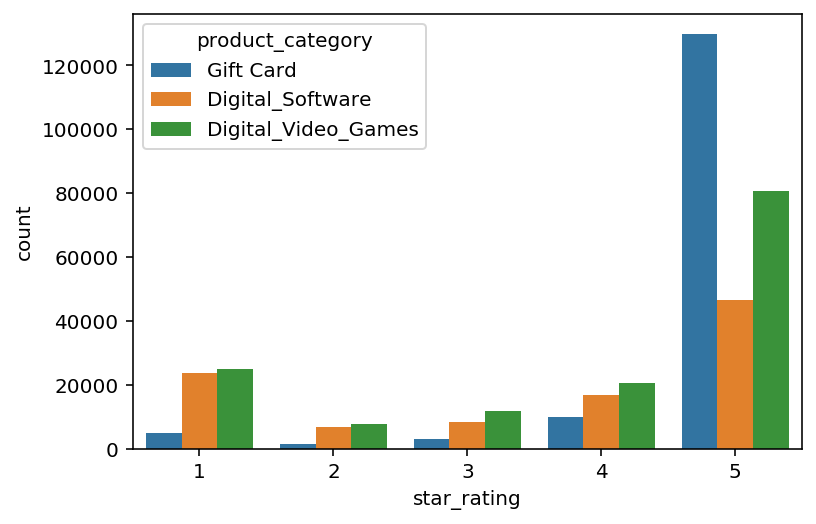

In [5]:
import seaborn as sns

sns.countplot(data=df, x="star_rating", hue="product_category")

### Upload the data

In [6]:
!mkdir -p ./transformed/

path = "./amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="bias/transformed", path=path)
data_s3_uri

's3://sagemaker-us-east-1-835319576252/bias/transformed/amazon_reviews_us_giftcards_software_videogames.csv'

# Analyze bias

In [7]:
from sagemaker import clarify

bias_report_output_path = "s3://{}/bias/generated_bias_report/data/".format(bucket)

data_config = clarify.DataConfig(
    s3_data_input_path=data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="star_rating",
    headers=df.columns.to_list(),
    dataset_type="text/csv",
)

### Setup `BiasConfig`
SageMaker Clarify also needs the sensitive columns (`facets`) and the desirable outcomes (`label_values_or_threshold`).

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star_rating==5` and `star_rating==4`.  `product_category` is the facet that we analyze in this run.

In [8]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5, 4], facet_name="product_category", group_name="product_category"
)

### Setup SageMaker Clarify Processing Job

In [9]:
processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=sess
)

### Run Processing Job

In [11]:
processor.run_pre_training_bias(
    data_config=data_config, data_bias_config=bias_config, methods="all", wait=False, logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-02-20-05-00-04-196
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/bias/transformed/amazon_reviews_us_giftcards_software_videogames.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/Clarify-Pretraining-Bias-2021-02-20-05-00-04-196/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/bias/generated_bias_report/data/', 'LocalPath': '/opt/ml/processing/outpu

In [15]:
bias_processing_job_name = processor.latest_job.job_name
print(run_bias_processing_job_name)

Clarify-Pretraining-Bias-2021-02-20-05-00-04-196


In [16]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, bias_processing_job_name
        )
    )
)

In [17]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, bias_processing_job_name
        )
    )
)

In [18]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, bias_processing_job_name, region
        )
    )
)

In [19]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=bias_processing_job_name, sagemaker_session=sess
)

### _This cell will take approximately 5-10 minutes to run._

In [20]:
%%time

running_processor.wait(logs=False)

..............................................!CPU times: user 192 ms, sys: 12.1 ms, total: 204 ms
Wall time: 3min 51s


### View bias report

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/data/

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML('<b>Review <a target="blank" href="./generated_bias_report/data/report.html">Unbalanced Bias Report</a></b>')
)

# Balance the dataset by `product_category` and `star_rating`

In [ ]:
df_group_by = df.groupby(["product_category", "star_rating"])
df_balanced_data = df_group_by.apply(lambda x: x.sample(df_group_by.size().min()).reset_index(drop=True))

In [ ]:
import seaborn as sns

sns.countplot(data=df_balanced_data, x="star_rating", hue="product_category")

# Analyze bias on balanced dataset with SageMaker Clarify

In [ ]:
path_balanced = "./amazon_reviews_us_giftcards_software_videogames_balanced.csv"
df_balanced.to_csv(path_balanced, index=False, header=True)

balanced_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="bias/transformed", path=path_balanced)
balanced_data_s3_uri

In [ ]:
from sagemaker import clarify

bias_report_balanced_output_path = "s3://{}/bias/generated_bias_report/balanced/".format(bucket)

balanced_data_config = clarify.DataConfig(
    s3_data_input_path=balanced_data_s3_uri,
    s3_output_path=bias_report_balanced_output_path,
    label="star_rating",
    headers=df_balanced.columns.to_list(),
    dataset_type="text/csv",
)

### Setup `BiasConfig`
SageMaker Clarify also needs the sensitive columns (`facets`) and the desirable outcomes (`label_values_or_threshold`).

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star_rating==5` and `star_rating==4`.  `product_category` is the facet that we analyze in this run.

In [ ]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5, 4], facet_name="product_category", group_name="product_category"
)

### Setup SageMaker Clarify Processing Job

In [ ]:
processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=sess
)

In [ ]:
processor.run_pre_training_bias(
    data_config=balanced_data_config, data_bias_config=bias_config, methods="all", wait=False, logs=False
)

In [ ]:
run_balanced_bias_processing_job_name = processor.latest_job.job_name
print(run_balanced_bias_processing_job_name)

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_balanced_bias_processing_job_name
        )
    )
)

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_balanced_bias_processing_job_name
        )
    )
)

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_balanced_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_balanced_bias_processing_job_name, sagemaker_session=sess
)

### _This cell will take approximately 5-10 minutes to run._

In [ ]:
%%time

running_processor.wait(logs=False)

### Analyze balanced bias report
Note that the class imbalance metric is equal across all product categories for the target label.

Download generated bias report from S3

In [ ]:
!aws s3 ls $bias_report_balanced_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/data_balanced/

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="./generated_bias_report/data_balanced/report.html">Balanced Bias Report</a></b>'
    )
)

# 5. Save subset of data for future labs

In [ ]:
!mkdir -p ./transformed/

path_balanced_subset = "./amazon_reviews_us_giftcards_software_videogames_balanced_subset.csv"
df_balanced_subset = df_balanced_data[["star_rating", "review_body"]].sample(df_balanced_data.shape[0])

In [ ]:
df_balanced_subset.to_csv(path_balanced_subset, index=False, header=True)

In [ ]:
!head -n 5 $path_balanced_subset